In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import scipy.constants as const
from scipy import integrate
%matplotlib inline

In [2]:
mpl.rc('lines', linewidth=2.1)
plt.rcParams['font.size'] = 26

## Introduction

Standeby has developed a collision presheath model based on Rieman plasma sheath set of equations. The model is collisionless, therefore it does not include ionization in the plasma sheath. The paper is centerer around the idea that Debye Sheath (DS) dissapeard at the grazing magnetic angles ($\alpha < \alpha^*$), then the Collisional Sheath (CS) can be completely characterized by the set of Rieman plasma sheath equations.

## Governing equations

All of the plasma sheath properties are connected to the normalized velocity of the wall approach $u$, which is determined as 
$$f\left(u\right) = c^2 + 2 \log\left(u/u_o\right) - u^2 - \left[\frac{c^2+ 1}{c \cos \alpha} - \tan \alpha \left(\frac{u^2 + 1}{u}\right)\right]^2$$

Where $c$ is a Mach number at the collisonal sheath entrance, and according to Chodura's definition it should be set to 1. For $z \rightarrow \infty$

$$ u_0 = c \sin \alpha$$
$$ v_0 = 0$$
$$ v_0 = c \cos \alpha$$

The resulting equation is valid for angle less than 
$$ \alpha^* = \sin^{-1} \left[ \sqrt{\frac{2 \pi m_e}{m_i} \left( 1+ \frac{T_i}{T_e}\right)} \right]$$

In [3]:
plasma_params = {'T_e': 1., 'T_i': 1., 'm_i': 2e-3/const.N_A, 'gamma': 1, 'c': 1., 'alpha': np.pi/180*2}

In [4]:
def calc_stangeby_params(plasma_params):
    '''
    Calculate parameters of the plasma sheath for stangeby's model
    ----------------------------------------------
    
    plasma_params - dictionary like
    '''
    plasma_params['u0'] = plasma_params['c'] *np.sin(plasma_params['alpha'])
    
    #calculate argument
    argument = 2 *np.pi *const.m_e /plasma_params['m_i'] *(1. + plasma_params['T_i']/plasma_params['T_e'])
    plasma_params['alpha_critical'] = np.arcsin(np.sqrt(argument))
    plasma_params['mach_cs_critical'] = np.sin(plasma_params['alpha'])/np.sqrt(argument)

In [5]:
#calculate all oft he parameters needed for Stangeby's model
calc_stangeby_params(plasma_params)
plasma_params

{'T_e': 1.0,
 'T_i': 1.0,
 'alpha': 0.03490658503988659,
 'alpha_critical': 0.058743482464458527,
 'c': 1.0,
 'gamma': 1,
 'm_i': 3.321078080854328e-27,
 'mach_cs_critical': 0.59444171789125311,
 'u0': 0.034899496702500969}

In [6]:
def func_f(u, plasma_params):
    c = plasma_params['c']
    u0 = plasma_params['u0']
    alpha = plasma_params['alpha']
    
    #find and calculte the result of te function
    w = (c + 1./c) /np.cos(alpha) - np.tan(alpha) * (u + 1./u)
    return c**2 + 2. *np.log(u/u0) - u**2 - w**2

In [7]:
func_f(1e-1, plasma_params)

0.37777961839573182

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


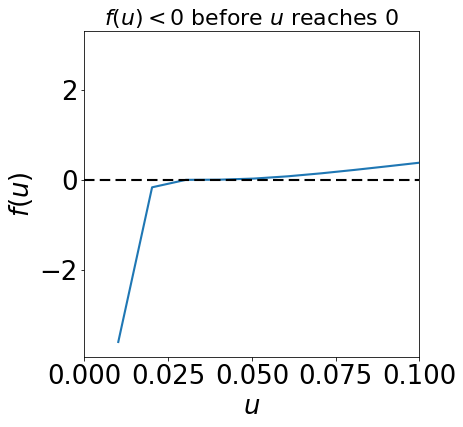

In [8]:
n_plots_f = 100
u_space_f = np.linspace(0,1, n_plots_f)

fig, ax = plt.subplots(figsize=(6,6))

f_values = [func_f(u, plasma_params) for u in u_space_f]

plt.plot(u_space_f, f_values, label=r'$f(u)$')
plt.plot([0,1], [0, 0], linestyle='--', dashes=(5, 2.5), color='black')
plt.xlim(0, 0.1)
plt.xlabel(r'$u$')
plt.ylabel(r'$f(u)$')
plt.title(r'$f(u)<0$ before $u$ reaches 0', fontsize=22)
plt.show()

The classical equation dependence between $u$ and $\zeta$ is defined by integral equation

$$ \zeta(u) = \int_u^1 \mathbf{d} u \frac{1-u^2}{u \sqrt{f(u)}}$$

In [9]:
def integrand_u(u, plasma_params):
    '''
    Defines integrand for zeta function
    -------------------------------------------
    
    parameters:
    u - float like
    plasma_params - dictionary like
    '''
    return (1. - u**2) /u /np.sqrt(func_f(u, plasma_params))

In [10]:
def get_sheath_zeta(u_space, plasma_params, max_u = 1):
    '''
    
    Find values of zeta for a given list of the u values
    -----------------------------------------------------
    
    u_space - sequence (ex. list, np.array), contains values between 0 and 1
    plasma_params - dictionary like
    max_u - float, if set to 1, provide classic profile
    '''
    #result = [integrate.romberg(integrand_u, u, max_u, args=(plasma_params,), show=True,divmax=100) for u in u_space]
    result = [integrate.fixed_quad(integrand_u, u, max_u, args=(plasma_params,), n=500)[0] for u in u_space]
    return result

In [11]:
def get_sheath_w(u_space, plasma_params):
    '''
    
    Finds the values of the drift velocity in ExB planes in the direction parallel to the wall
    -----------------------------------------------------
    
    u_space - sequence (ex. list, np.array), contains values between 0 and 1
    plasma_params - dictionary like
    '''

    #conversion function of w
    f_w = lambda u: 2. - (u + 1./u) *np.sin(plasma_params['alpha'])/np.cos(plasma_params['alpha'])
    w = [f_w(u) for u in u_space]
    
    return w

In [12]:
def get_sheath_v(u_space, w_space, plasma_params):
    '''
    
    Finds the values of the drift velocity in the direction of ExB drift
    -----------------------------------------------------
    
    u_space - sequence (ex. list, np.array), contains values between 0 and 1
    plasma_params - dictionary like
    '''
    
    alpha = plasma_params['alpha']
    
    #conversion function for v
    f_v = lambda u, w: np.sqrt(2 *np.log(u/np.sin(alpha)) + 1 - u**2 -w**2)
    v = [f_v(u, w) for u, w in zip(u_space, w_space)]
    
    return v

In [13]:
def get_sheath_potential(u_space, plasma_params):
    '''
    
    Calculates plasma potential in physical units
    '''
    
    #scale for plasma potential
    scale = -plasma_params['T_e']
    
    #evaulate potential
    potential = [scale *np.log(u) for u in u_space]
    
    return potential

In [14]:
np.logspace(np.log10(1e-3), np.log10(0.6), 5)

array([ 0.001     ,  0.00494923,  0.0244949 ,  0.12123093,  0.6       ])

In [15]:
def get_sheath_density(u_space, potential, plasma_params):
    '''
    
    Calculates plasma potential in relative units
    '''
    
    #scale for electrostatic potential
    scale = plasma_params['T_e']
    
    #scale for density
    #evaulate potential
    density = [np.exp(u/scale) for u in potential]
    
    return density

In [16]:
n_points = 100
u_space = np.linspace(0, 1, n_points)

#find sheath location
zeta_space_classic = get_sheath_zeta(u_space, plasma_params)
zeta_space_stangeby = get_sheath_zeta(u_space, plasma_params, max_u = plasma_params['mach_cs_critical'])

w_space_stangeby = get_sheath_w(u_space, plasma_params)
v_space_stangeby = get_sheath_v(u_space, w_space_stangeby, plasma_params)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt


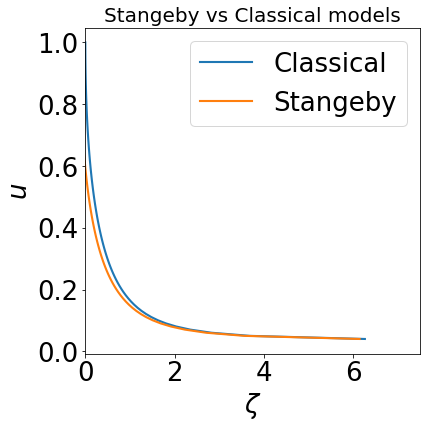

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

plt.plot(zeta_space_classic, u_space, label = 'Classical')
plt.plot(zeta_space_stangeby, u_space, label = 'Stangeby')
plt.xlim(0, 7.5)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$u$')
plt.legend()
plt.title('Stangeby vs Classical models', fontsize=20)
plt.show()

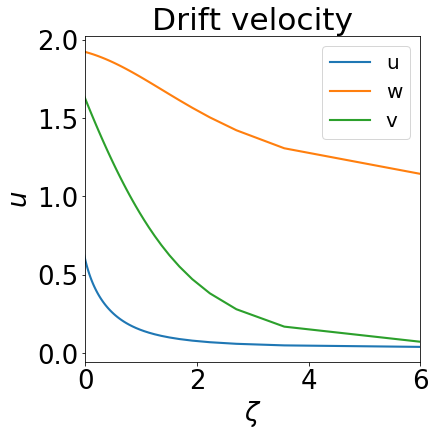

In [18]:
fig, ax = plt.subplots(figsize=(6,6))

plt.plot(zeta_space_stangeby, u_space, label = 'u')
plt.plot(zeta_space_stangeby, w_space_stangeby, label = 'w')
plt.plot(zeta_space_stangeby, v_space_stangeby, label = 'v')
plt.xlim(0, 6)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$u$')
plt.title('Drift velocity')
plt.legend(fontsize=20)
plt.show()

## Import precalculated Stangeby's coeficients

Stangeby has evaluated coefficients of his model for grazing magnetic angles

In [19]:
normal_coeff_file = 'table_c1.csv'
grazing_coeff_file = 'table_c2.csv'

In [20]:
df_normal = pd.read_csv(normal_coeff_file)
df_normal.head()

,angle,min_zeta,max_zeta,a6,a5,a4,a3,a2,a1,a0
0,10,0,-1,14.875000,49.285000,64.338000,42.284000,15.14200,3.36460,0.9539
1,10,-1,-10,0.000009,0.000327,0.004742,0.035860,0.15259,0.36505,0.6092
2,5,0,-1,18.831000,62.159000,80.793000,52.830000,18.80600,4.11530,0.9438
3,5,-1,-10,0.000012,0.000417,0.005937,0.043777,0.17938,0.40338,0.5171
4,4,0,-1,20.226000,66.460000,85.922000,55.849000,19.76400,4.30040,0.9405


In [21]:
df_grazing = pd.read_csv(grazing_coeff_file)
df_grazing.head()

,mass,angle,min_zeta,max_zeta,a6,a5,a4,a3,a2,a1,a0
0,1.0,4,0,-1,6.306900,21.751000,30.084000,21.648000,9.09520,2.69010,0.8324
1,1.0,4,-1,-10,0.000012,0.000420,0.005960,0.043776,0.17807,0.39509,0.4801
2,1.0,3,0,-1,1.145200,4.212000,6.422200,5.432000,3.04610,1.41740,0.6316
3,1.0,3,-1,-10,0.000011,0.000376,0.005315,0.038802,0.15667,0.34397,0.4032
4,1.0,2,0,-1,0.185520,0.741370,1.291300,1.366500,1.08940,0.75111,0.4219


$\zeta$ is a normalized by larmour radius distance fom the wall

## Preliminary plots of the plasma profiles

## Setting up plasma parameters dictionary

In [22]:
#plasma_params = {'T_e': 1, 'T_i': 1, 'm_i': 1e-3/const.N_A, 'gamma': 1}

In [23]:
def bohm_speed(params):

SyntaxError: unexpected EOF while parsing (<ipython-input-23-d0c66cfbf96a>, line 1)

In [ ]:
def zeta(z, rho_i)